<a href="https://colab.research.google.com/github/SowjanyaKiran/RNN_NIFTY_Prediction/blob/main/RNN_NIFTY_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing important libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting the seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Specification
TICKER = "^NSEI" # NIFTY 50 Yahoo Finance Ticker
START_DATE = "2010-01-01"
END_DATE = None
USE_FEATURES = ['Close']
TIME_STEPS = 60 # Sequence Length
TEST_SPLIT = 0.2
VIZ_SAMPLE_DAYS = 1000 # how many recent days to show in some plots
EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
# Downloading the data
print("Downloading the data for", TICKER)
df = yf.download(TICKER, START_DATE, END_DATE, progress = False)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop = True)
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
0,2010-01-04,5232.200195,5238.450195,5167.100098,5200.899902,0
1,2010-01-05,5277.899902,5288.350098,5242.399902,5277.149902,0
2,2010-01-06,5281.799805,5310.850098,5260.049805,5278.149902,0
3,2010-01-07,5263.100098,5302.549805,5244.750000,5281.799805,0
4,2010-01-08,5244.750000,5276.750000,5234.700195,5264.250000,0


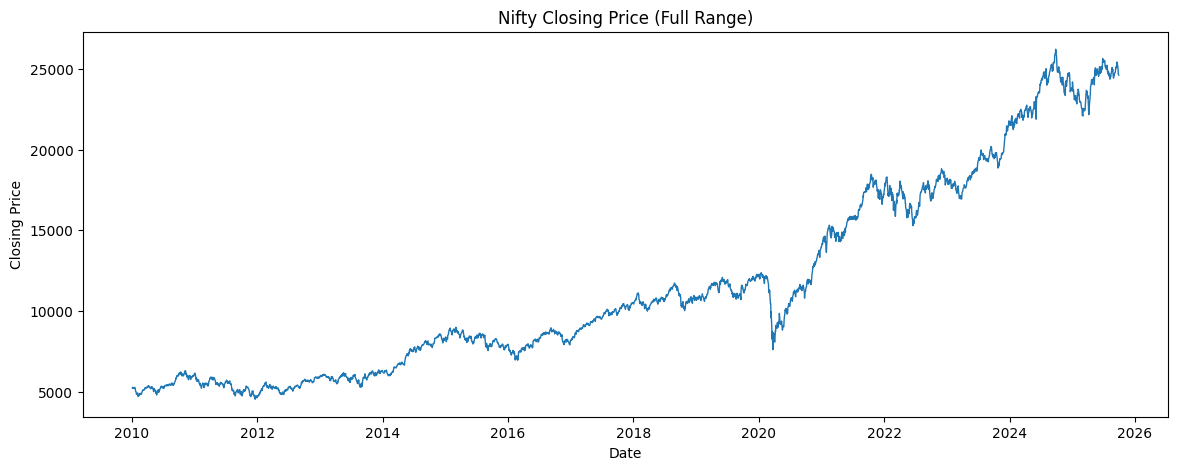

In [ ]:
# Plots
plt.figure(figsize = (14, 5))
plt.plot(df['Date'], df['Close'], lw = 1)
plt.title('Nifty Closing Price (Full Range)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

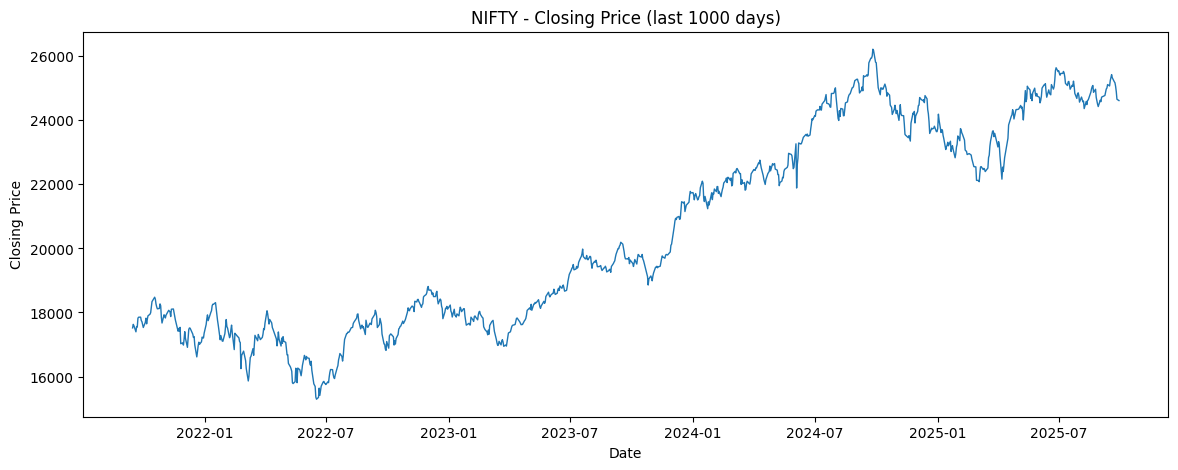

In [ ]:
# Last 1000 rows in the data
plt.figure(figsize = (14, 5))
plt.plot(df['Date'].iloc[-VIZ_SAMPLE_DAYS:], df['Close'].iloc[-VIZ_SAMPLE_DAYS:], lw = 1)
plt.title(f"NIFTY - Closing Price (last {VIZ_SAMPLE_DAYS} days)")
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

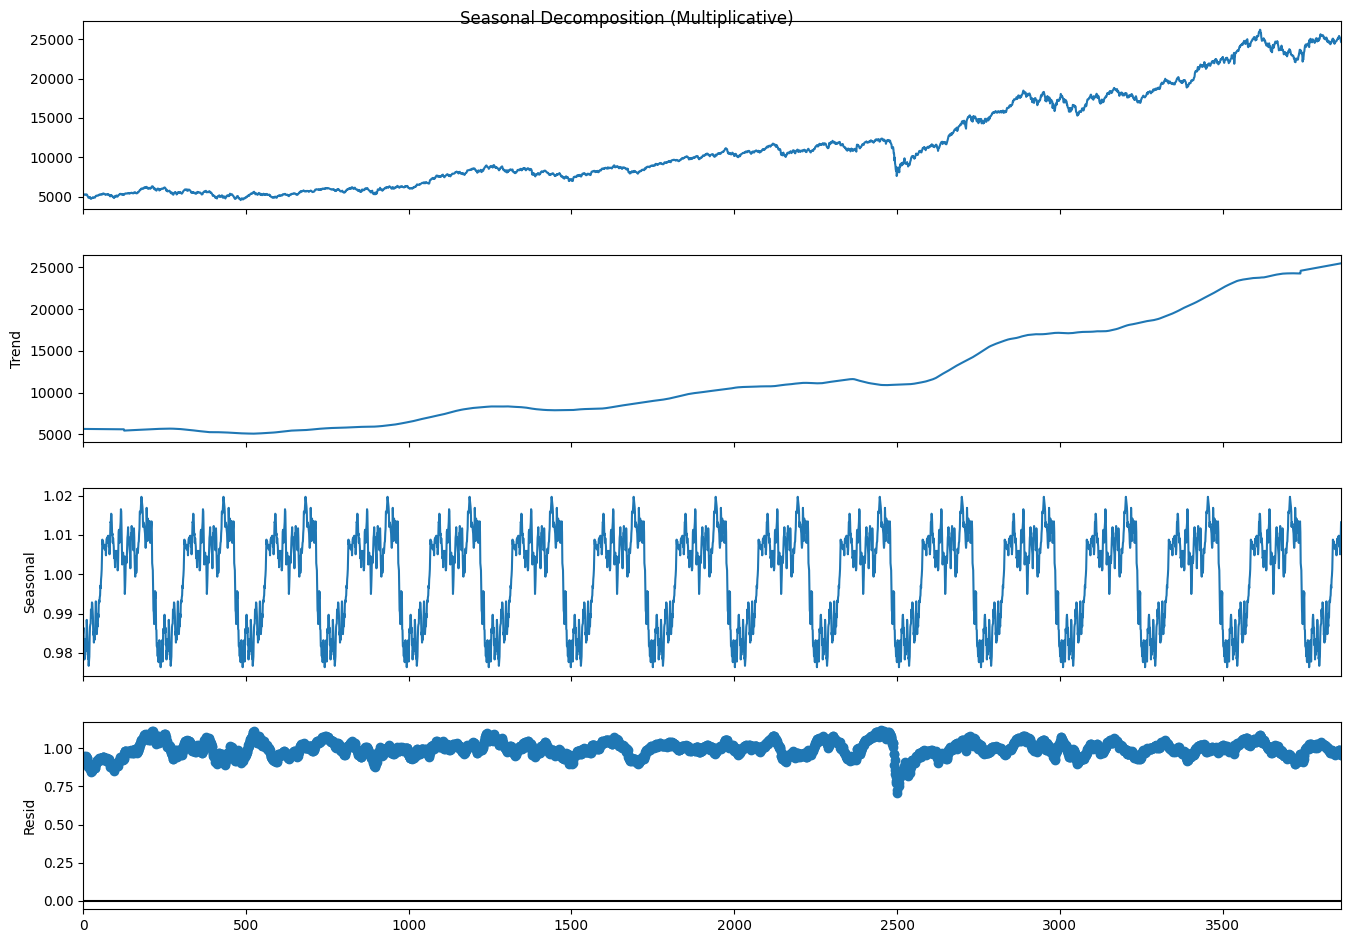

In [ ]:
# Decomposition
try:
  decom_period = 252
  decomposed = seasonal_decompose(df['Close'], model = 'multiplicative',
                                  period = decom_period, extrapolate_trend = 'freq')
  fig = decomposed.plot()
  fig.set_size_inches(15, 10)
  plt.suptitle('Seasonal Decomposition (Multiplicative)')
  plt.show()
except Exception as e:
  print('Seasonal Decomposition skipped {reason} :', e)

In [ ]:
# Preprocessing
features = USE_FEATURES.copy()
data = df[features].astype('float32').values
print('Using Features :', features)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

Using Features : ['Close']


In [ ]:
# Created sequences for supervised learning
def create_sequences_multivariate(data_array, time_steps):
  X, y = [], []
  for i in range(time_steps, len(data_array)):
    X.append(data_array[i - time_steps : i])
    y.append(data_array[i])
  X = np.array(X)
  y = np.array(y)
  return X, y

In [ ]:
# Driver Code
X, y = create_sequences_multivariate(data_scaled, TIME_STEPS)
print('X shape :', X.shape)
print('y shape :', y.shape)

X shape : (3806, 60, 1)
y shape : (3806, 1)


In [ ]:
# Train Test Split
split = int(X.shape[0] * (1 - TEST_SPLIT))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [ ]:
# Model Builders
n_features = X.shape[-1]
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [ ]:
# Function for RNN
def build_rnn(units_list = [64], dropout = 0.2, input_shape = (TIME_STEPS, n_features)):
  model = Sequential()
  for i, units in enumerate(units_list):
    return_seq = (i < len(units_list) - 1)
    if i == 0:
      model.add(SimpleRNN(units, return_sequences = return_seq, input_shape = input_shape))
    else:
      model.add(SimpleRNN(units, return_sequences = return_seq))
    model.add(Dropout(dropout))
    model.add(Dense(n_features))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

In [ ]:
# Function for LSTM
def build_lstm(units_list = [64], dropout = 0.2, input_shape = (TIME_STEPS, n_features)):
  model = Sequential()
  for i, units in enumerate(units_list):
    return_seq = (i < len(units_list) - 1)
    if i == 0:
      model.add(LSTM(units, return_sequences = return_seq, input_shape = input_shape))
    else:
      model.add(LSTM(units, return_sequences = return_seq))
    model.add(Dropout(dropout))
    model.add(Dense(n_features))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

In [ ]:
# Function for GRU
def build_gru(units_list = [64], dropout = 0.2, input_shape = (TIME_STEPS, n_features)):
  model = Sequential()
  for i, units in enumerate(units_list):
    return_seq = (i < len(units_list) - 1)
    if i == 0:
      model.add(GRU(units, return_sequences = return_seq, input_shape = input_shape))
    else:
      model.add(GRU(units, return_sequences = return_seq))
    model.add(Dropout(dropout))
    model.add(Dense(n_features))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

In [ ]:
# Define Model Variants
configs = [
    ("RNN-32", build_rnn(units_list = [32], dropout = 0.1)),
    ("RNN-64-32", build_rnn(units_list = [64, 32], dropout = 0.2)),
    ("RNN-128-64-32", build_rnn(units_list = [128, 64, 32], dropout = 0.3)),
    ("LSTM-32", build_lstm(units_list = [32], dropout = 0.1)),
    ("LSTM-64-32", build_lstm(units_list = [64, 32], dropout = 0.2)),
    ("LSTM-128-64-32", build_lstm(units_list = [128, 64, 32], dropout = 0.3)),
    ("GRU-32", build_gru(units_list = [32], dropout = 0.1)),
    ("GRU-64-32", build_gru(units_list = [64, 32], dropout = 0.2)),
    ("GRU-128-64-32", build_gru(units_list = [128, 64, 32], dropout = 0.3)),
]

In [ ]:
# Training all the variants and recording metrics and runtime
history = {}
results = {}
timings = {}
predictions = {}

for name, model in configs:
  print("\n============================================================================")
  print('Training Model :', name)
  print('\n', model.summary())
  start = time.time()
  h =  model.fit(
      X_train, y_train,
      epochs = EPOCHS,
      batch_size = BATCH_SIZE,
      validation_split = 0.15,
      callbacks = [early_stop],
      verbose = 1
  )
  elapsed = time.time() - start

  # Predict and rescale the target
  y_pred_scaled = model.predict(X_test)
  y_pred_rescaled = scaler.inverse_transform(y_pred_scaled)
  y_test_rescaled = scaler.inverse_transform(y_test)

  # Evaluate the model
  close_idx = features.index('Close')
  rmse = math.sqrt(mean_squared_error(y_test_rescaled[:, close_idx], y_pred_rescaled[:, close_idx]))
  mae = np.mean(np.abs(y_pred_rescaled[:, close_idx] - y_test_rescaled[:, close_idx]))

  print(f"{name} RMSE (Close) : {rmse:.3f}, MAE (Close) : {mae:.3f}, Time : {elapsed:.1f}s")
  history[name] = h.history
  results[name] = [rmse, mae]
  timings[name] = elapsed
  predictions[name] = {"y_true" : y_test_rescaled[:, close_idx], "y_pred" : y_pred_rescaled[:, close_idx]}


Training Model : RNN-32


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0048 - mae: 0.0480 - val_loss: 0.0143 - val_mae: 0.1137
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.4565e-04 - mae: 0.0219 - val_loss: 0.0070 - val_mae: 0.0788
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9165e-04 - mae: 0.0175 - val_loss: 0.0029 - val_mae: 0.0489
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8668e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0358
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7550e-04 - mae: 0.0137 - val_loss: 7.8071e-04 - val_mae: 0.0242
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.2235e-04 - mae: 0.0132 - val_loss: 0.0011 - val_mae: 0.0301
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4400e-04 - mae: 0.0114 - val_loss: 7.5595e-04 - val_mae: 0.0247
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5490e-04 - mae: 0.0116 - val_loss: 3.4226e-04 - val_mae: 0.0159
Epoch 9/20
81/81 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 60, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 1)          │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,410 (21.13 KB)

 Trainable params: 5,410 (21.13 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0199 - mae: 0.0901 - val_loss: 0.0338 - val_mae: 0.1762
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0017 - mae: 0.0299 - val_loss: 0.0141 - val_mae: 0.1117
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 0.0100 - val_mae: 0.0946
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.6304e-04 - mae: 0.0213 - val_loss: 0.0108 - val_mae: 0.0988
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 8.3642e-04 - mae: 0.0209 - val_loss: 0.0061 - val_mae: 0.0729
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 7.9008e-04 - mae: 0.0199 - val_loss: 0.0029 - val_mae: 0.0484
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.2578e-04 - mae: 0.0195 - val_loss: 0.0062 - val_mae: 0.0745
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 6.3073e-04 - mae: 0.0182 - val_loss: 0.0039 - val_mae: 0.0575
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 60, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60, 1)          │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 60, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 60, 1)          │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,179 (86.64 KB)

 Trainable params: 22,179 (86.64 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 0.0126 - mae: 0.0760 - val_loss: 0.0213 - val_mae: 0.1403
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0028 - mae: 0.0393 - val_loss: 0.0101 - val_mae: 0.0926
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0025 - mae: 0.0366 - val_loss: 0.0146 - val_mae: 0.1144
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0021 - mae: 0.0336 - val_loss: 0.0178 - val_mae: 0.1278
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0022 - mae: 0.0336 - val_loss: 0.0089 - val_mae: 0.0862
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0021 - mae: 0.0333 - val_loss: 0.0049 - val_mae: 0.0600
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0019 - mae: 0.0316 - val_loss: 0.0223 - val_mae: 0.1442
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0020 - mae: 0.0329 - val_loss: 0.0077 - val_mae: 0.0790
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - los

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0061 - mae: 0.0548 - val_loss: 5.1699e-04 - val_mae: 0.0175
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.4908e-04 - mae: 0.0145 - val_loss: 3.3432e-04 - val_mae: 0.0142
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.5921e-04 - mae: 0.0131 - val_loss: 2.8902e-04 - val_mae: 0.0133
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.7464e-04 - mae: 0.0118 - val_loss: 3.5118e-04 - val_mae: 0.0140
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.8130e-04 - mae: 0.0117 - val_loss: 4.9123e-04 - val_mae: 0.0192
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.8161e-04 - mae: 0.0117 - val_loss: 2.2751e-04 - val_mae: 0.0118
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3959e-04 - mae: 0.0110 - val_loss: 2.6348e-04 - val_mae: 0.0133
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1410e-04 - mae: 0.0105 - val_loss: 3.9464e-04 - val_mae: 0.01

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 60, 1)          │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,346 (83.38 KB)

 Trainable params: 21,346 (83.38 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0088 - mae: 0.0678 - val_loss: 0.0011 - val_mae: 0.0292
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 8.5312e-04 - mae: 0.0209 - val_loss: 7.6169e-04 - val_mae: 0.0232
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 6.0445e-04 - mae: 0.0175 - val_loss: 8.8638e-04 - val_mae: 0.0254
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 5.6093e-04 - mae: 0.0171 - val_loss: 6.2992e-04 - val_mae: 0.0211
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 5.3043e-04 - mae: 0.0162 - val_loss: 6.8971e-04 - val_mae: 0.0225
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 4.6699e-04 - mae: 0.0151 - val_loss: 6.0317e-04 - val_mae: 0.0209
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 4.5687e-04 - mae: 0.0150 - val_loss: 6.1379e-04 - val_mae: 0.0212
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 4.4495e-04 - mae: 0.0147 - val_loss: 0.0013 - val_mae: 0.0329
Epoc

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 60, 1)          │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 60, 1)          │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,035 (343.89 KB)

 Trainable params: 88,035 (343.89 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 0.0138 - mae: 0.0867 - val_loss: 0.0086 - val_mae: 0.0889
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.0037 - val_mae: 0.0557
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 9.1178e-04 - mae: 0.0218 - val_loss: 0.0056 - val_mae: 0.0711
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - loss: 8.2128e-04 - mae: 0.0208 - val_loss: 0.0046 - val_mae: 0.0636
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - loss: 7.9049e-04 - mae: 0.0199 - val_loss: 0.0013 - val_mae: 0.0310
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - loss: 6.3535e-04 - mae: 0.0183 - val_loss: 0.0046 - val_mae: 0.0639
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 6.1552e-04 - mae: 0.0178 - val_loss: 0.0029 - val_mae: 0.0493
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 6.3831e-04 - mae: 0.0185 - val_loss: 0.0028 - val_mae: 0.0492
24/24 ━━━━━━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0073 - mae: 0.0634 - val_loss: 1.8516e-04 - val_mae: 0.0102
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.3294e-04 - mae: 0.0126 - val_loss: 1.3720e-04 - val_mae: 0.0090
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.8359e-04 - mae: 0.0118 - val_loss: 1.2803e-04 - val_mae: 0.0090
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 2.1952e-04 - mae: 0.0104 - val_loss: 1.5017e-04 - val_mae: 0.0102
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 2.0575e-04 - mae: 0.0101 - val_loss: 1.1934e-04 - val_mae: 0.0083
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0375e-04 - mae: 0.0101 - val_loss: 1.1548e-04 - val_mae: 0.0087
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.8458e-04 - mae: 0.0098 - val_loss: 1.0737e-04 - val_mae: 0.0078
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.5489e-04 - mae: 0.0091 - val_loss: 1.0635e-04 - val_mae: 0.00

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 60, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 60, 1)          │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322 (63.76 KB)

 Trainable params: 16,322 (63.76 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0128 - mae: 0.0868 - val_loss: 7.0692e-04 - val_mae: 0.0213
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 7.6330e-04 - mae: 0.0192 - val_loss: 4.4173e-04 - val_mae: 0.0162
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 5.3560e-04 - mae: 0.0170 - val_loss: 3.0981e-04 - val_mae: 0.0149
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 4.9051e-04 - mae: 0.0165 - val_loss: 8.2289e-04 - val_mae: 0.0260
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 4.5005e-04 - mae: 0.0156 - val_loss: 4.4296e-04 - val_mae: 0.0185
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 3.9597e-04 - mae: 0.0146 - val_loss: 1.8431e-04 - val_mae: 0.0103
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 3.9650e-04 - mae: 0.0149 - val_loss: 3.4546e-04 - val_mae: 0.0161
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 3.2788e-04 - mae: 0.0132 - val_loss: 7.7671e-04 - val_mae: 0.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 60, 1)          │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 60, 1)          │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,755 (260.76 KB)

 Trainable params: 66,755 (260.76 KB)

 Non-trainable params: 0 (0.00 B)


 None
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 0.0134 - mae: 0.0882 - val_loss: 5.9394e-04 - val_mae: 0.0210
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0020 - val_mae: 0.0413
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - loss: 8.8769e-04 - mae: 0.0224 - val_loss: 3.0722e-04 - val_mae: 0.0144
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - loss: 7.0868e-04 - mae: 0.0194 - val_loss: 4.9621e-04 - val_mae: 0.0194
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - loss: 6.1760e-04 - mae: 0.0185 - val_loss: 0.0010 - val_mae: 0.0291
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - loss: 5.9428e-04 - mae: 0.0179 - val_loss: 2.4464e-04 - val_mae: 0.0127
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - loss: 5.9236e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0354
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 4.9477e-04 - mae: 0.0163 - val_loss: 9.5931e-04 - val_mae: 0.02

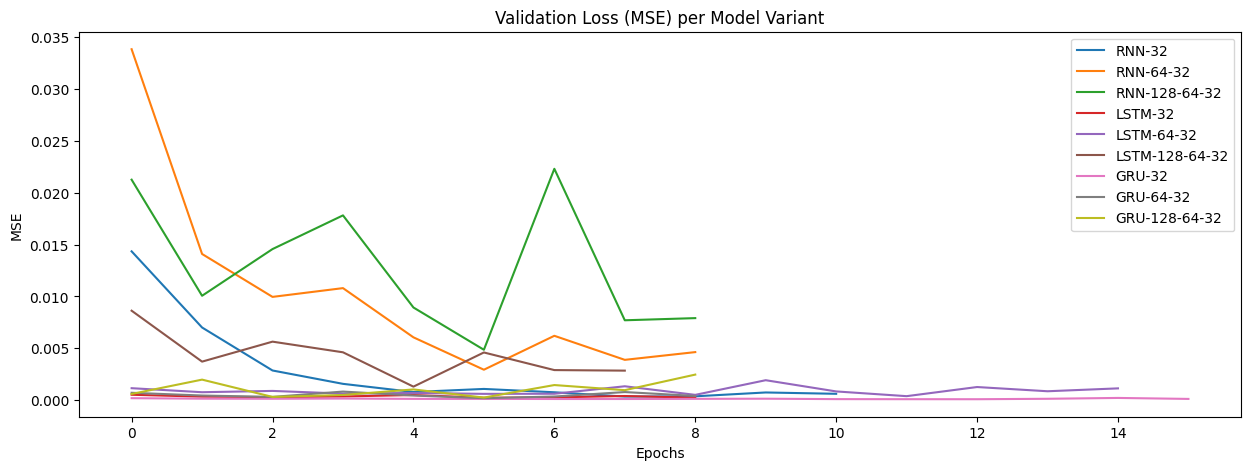

In [ ]:
# Visual Comparison
plt.figure(figsize = (15, 5))
for name, h in history.items():
  if "val_loss" in h:
    plt.plot(h['val_loss'], label = name)
plt.title("Validation Loss (MSE) per Model Variant")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

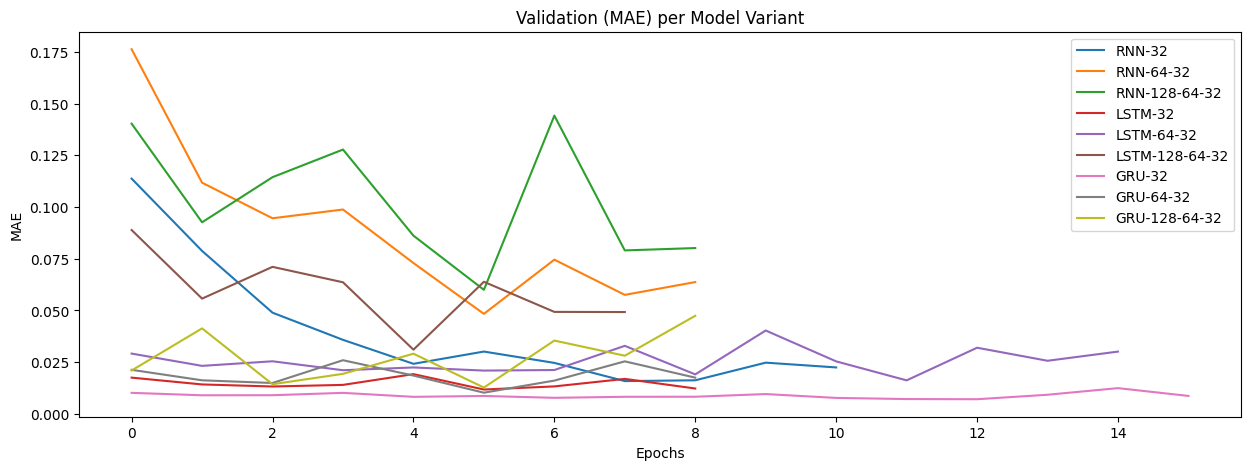

In [ ]:
# Visual Comparison
plt.figure(figsize = (15, 5))
for name, h in history.items():
  if "val_mae" in h:
    plt.plot(h['val_mae'], label = name)
plt.title("Validation (MAE) per Model Variant")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Getting the best model
best_name = min(results.keys(), key = lambda k : results[k][0])
print('Best Model by RMSE (Close):', best_name, results[best_name])

y_true = predictions[best_name]['y_true']
y_pred = predictions[best_name]['y_pred']

Best Model by RMSE (Close): GRU-32 [257.74255869471773, np.float32(202.43573)]


<function matplotlib.pyplot.show(close=None, block=None)>

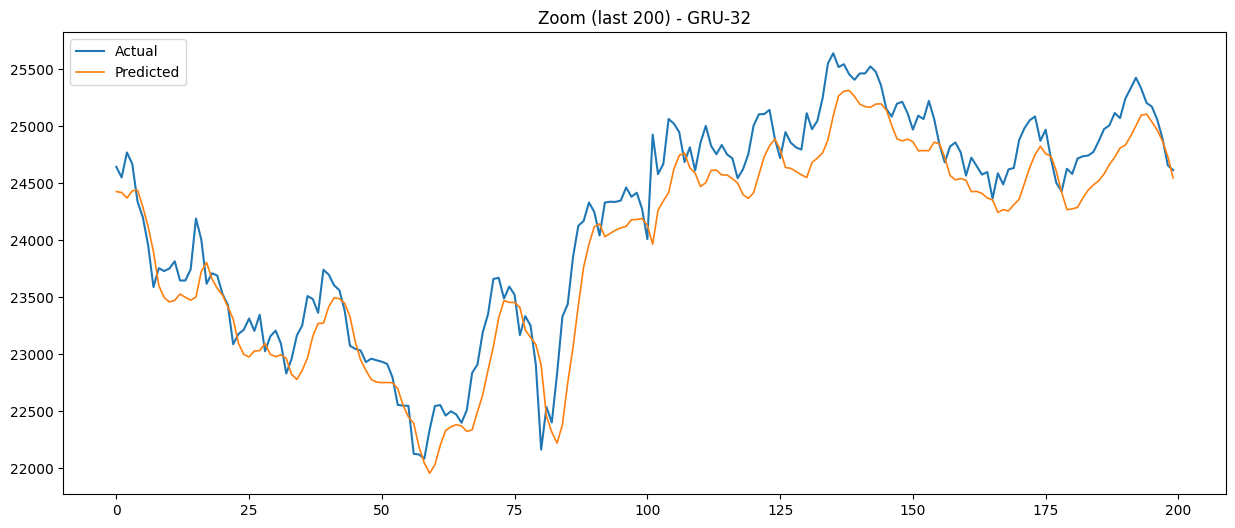

In [ ]:
# Zoom into the last 200 test points
zoom_n = min(200, len(y_true))
plt.figure(figsize = (15, 6))
plt.plot(y_true[-zoom_n:], label = 'Actual', lw = 1.5)
plt.plot(y_pred[-zoom_n:], label = 'Predicted', lw = 1.2)
plt.title(f"Zoom (last {zoom_n}) - {best_name}")
plt.legend()
plt.show